In [1]:
import tensorflow as tf
import numpy as np
import gym
from pylab import *
import scipy.misc

In [2]:
%matplotlib notebook

In [459]:
G = 0.9
N_ACTIONS = 9
ACTIONS = np.arange(N_ACTIONS)

## Network setup

In [460]:
tf.reset_default_graph()
sess = tf.Session()

graph_s = tf.placeholder(tf.float32, [None, 84, 84, 4])
graph_action = tf.placeholder(tf.int64, [None])
graph_advantage = tf.placeholder(tf.float32, [None])

for scope in ['network1', 'network2']:
    with tf.variable_scope(scope):
        x = tf.layers.conv2d(
                inputs=graph_s,
                filters=32,
                kernel_size=8,
                strides=4,
                activation=tf.nn.relu)

        x = tf.layers.conv2d(
                inputs=x,
                filters=64,
                kernel_size=4,
                strides=2,
                activation=tf.nn.relu)

        x = tf.layers.conv2d(
                inputs=x,
                filters=64,
                kernel_size=3,
                strides=1,
                activation=tf.nn.relu)

        w, h, f = x.shape[1:]
        x = tf.reshape(x, [-1, int(w * h * f)])

        x = tf.layers.dense(
                inputs=x,
                units=512,
                activation=tf.nn.relu)

        a_logits = tf.layers.dense(
                inputs=x,
                units=N_ACTIONS,
                activation=None)

        if scope == 'network1':
            a_softmax = tf.nn.softmax(a_logits)
        else:
            v = tf.layers.dense(
                inputs=x,
                units=1,
                activation=None)

p = 0
for i in range(N_ACTIONS):
    p += tf.cast(tf.equal(graph_action, i), tf.float32) * a_softmax[:, i]
nlp = -1 * tf.log(p)
loss = tf.reduce_mean(nlp * graph_advantage)    
t = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

## Action probability selection test

In [461]:
sess.run(tf.global_variables_initializer())
s = np.random.random((1, 84, 84, 4))
s = np.vstack([s] * N_ACTIONS)
expected = -1 * np.log(sess.run(a_softmax, feed_dict={graph_s: s})[0])
actual = sess.run(nlp, feed_dict={graph_s: s, graph_action: np.arange(N_ACTIONS)})
np.testing.assert_allclose(expected, actual)

## Basic training test

In [462]:
sess.run(tf.global_variables_initializer())
n = 5
s = np.random.random((1, 84, 84, 4))
s = np.vstack([s] * n)

print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
a = [0] * n
ad = [1] * n
for i in range(3):
    sess.run(t, feed_dict={graph_s: s, graph_action: a, graph_advantage: ad})
    print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
# now the probability of action[0] will be very close to 1,
# so the gradients will be too small to work
# so reset
sess.run(tf.global_variables_initializer())
print()
print(sess.run(a_softmax, feed_dict={graph_s: s})[0])
a = [0] * n
ad = [-1] * n
for i in range(3):
    sess.run(t, feed_dict={graph_s: s, graph_action: a, graph_advantage: ad})
    print(sess.run(a_softmax, feed_dict={graph_s: s})[0])

[ 0.10848492  0.11034466  0.12670109  0.09328968  0.10463993  0.10683646
  0.10637622  0.11041979  0.13290717]
[ 0.13351598  0.10380731  0.12250793  0.09152929  0.10391526  0.10328127
  0.1042342   0.10853054  0.12867832]
[ 0.16180326  0.09721972  0.11870607  0.08919366  0.10227831  0.09874429
  0.10130129  0.1062222   0.12453128]
[ 0.19548681  0.09054251  0.11491486  0.08647115  0.09997077  0.09356444
  0.09710278  0.10331546  0.11863115]

[ 0.10616729  0.1070467   0.10883211  0.10444742  0.12317429  0.12239089
  0.11449856  0.10308765  0.11035509]
[ 0.08857553  0.11086352  0.10976861  0.10469551  0.12524326  0.12662691
  0.11535983  0.10677321  0.11209368]
[ 0.07339845  0.11418556  0.11005178  0.10413864  0.12768351  0.13081793
  0.11639562  0.1103394   0.11298914]
[ 0.05945676  0.117672    0.11068442  0.10322943  0.13025348  0.13469502
  0.11736766  0.11374114  0.11290003]


## Utils

In [337]:
def copy_network():
    n1_dict = {var.name: var for var in tf.trainable_variables() if 'network1' in var.name}
    n2_dict = {var.name: var for var in tf.trainable_variables() if 'network2' in var.name}
    copy_ops = []
    for name, var in n2_dict.items():
        op = var.assign(n1_dict[name.replace('network2', 'network1')].value())
        copy_ops.append(op)
    sess.run(copy_ops)
    
def with_prob(p):
    if np.random.random() < p:
        return True
    else:
        return False

def discount_rewards(r, G):
    r2 = np.zeros_like(np.array(r).astype(np.float32))
    r2[-1] = r[-1]
    for i in range(len(r2)-2, -1, -1):
        r2[i] = G * r2[i+1]
    return r2

In [338]:
print(discount_rewards([0, 0, 0, 1], 0.9))

[ 0.72899997  0.81        0.89999998  1.        ]


## Dummy environment

In [469]:
class DummyEnv:
    action_space = gym.spaces.discrete.Discrete(2)
    N_STATES = 5
    N_REWARDED_SEQUENCES = int(N_ACTIONS ** N_STATES / 10)
    
    def __init__(self):
        self.rewarded_sequences = np.random.choice(ACTIONS, size=(self.N_REWARDED_SEQUENCES, self.N_STATES))
        self.o = np.random.normal(size=(self.N_STATES, 84, 84, 4))
    
    def reset(self):
        self.i = 0
        self.history = []
        return self.o[self.i]
    
    def step(self, a):
        self.history.append(a)

        if self.i != self.N_STATES - 1:
            reward = 0
            done = False
            self.i += 1
        else:
            reward = 0
            for seq in self.rewarded_sequences:
                if np.array_equal(self.history, seq):
                    reward = 1
            done = True
        return self.o[self.i], reward, done, None

In [470]:
env = DummyEnv()
print(env.rewarded_sequences)

[[4 2 4 5 2]
 [8 3 8 4 3]
 [0 4 5 6 0]
 ..., 
 [4 1 5 4 1]
 [7 3 0 1 7]
 [0 7 8 6 6]]


In [471]:
def test_seq(seq):
    for a in seq:
        print("Took action", a)
        _, reward, done, _ = env.step(a)
        print("Got reward ", reward)
        print("Done:", done)

env.reset()
test_seq([0, 0, 0, 0, 0])
print()
env.reset()
test_seq(env.rewarded_sequences[0])

Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: False
Took action 0
Got reward  0
Done: True

Took action 4
Got reward  0
Done: False
Took action 2
Got reward  0
Done: False
Took action 4
Got reward  0
Done: False
Took action 5
Got reward  0
Done: False
Took action 2
Got reward  1
Done: True


## Testing proper

In [508]:
sess.run(tf.global_variables_initializer())

In [509]:
env = DummyEnv()
print(env.rewarded_sequences)

[[2 1 4 3 8]
 [3 0 1 2 5]
 [4 8 0 0 8]
 ..., 
 [7 8 2 2 3]
 [0 8 3 1 7]
 [3 7 1 6 1]]


### Manual testing

In [456]:
sess.run(t, feed_dict={graph_s: [env.o[2]], graph_action: [1], graph_advantage: [1]})
sess.run(a_softmax, feed_dict={graph_s: env.o})

array([[ 0.39359078,  0.60640925],
       [ 0.31771442,  0.68228555],
       [ 0.24010767,  0.75989234],
       [ 0.32243866,  0.67756128],
       [ 0.35887474,  0.64112526]], dtype=float32)

### Testing with environment

In [510]:
rpe = [0]

In [513]:
for i in range(1000):
    o = env.reset()
    done = False
    rewards = []
    actions = []
    states = []
    s2 = []
    while not done:
        states.append(o)
        s2.append(np.sum(o))
        a_p = sess.run(a_softmax, feed_dict={graph_s: [o]})[0]
        a = np.random.choice(ACTIONS, p=a_p)
        actions.append(a)
        o, r, done, _ = env.step(a)
        rewards.append(r)
    
    rpe.append(rpe[-1] + 0.1 * (rewards[-1] - rpe[-1]))
    
    rewards = discount_rewards(rewards, G=1.0)
    """
    print("Actions:", actions)
    print("Rewards:", rewards)
    print()
    """
    
    if rewards[-1] == 0:
        continue
    
    #print("Training!")
    sess.run(t, feed_dict={graph_s: states, graph_action: actions, graph_advantage: rewards})

<IPython.core.display.Javascript object>


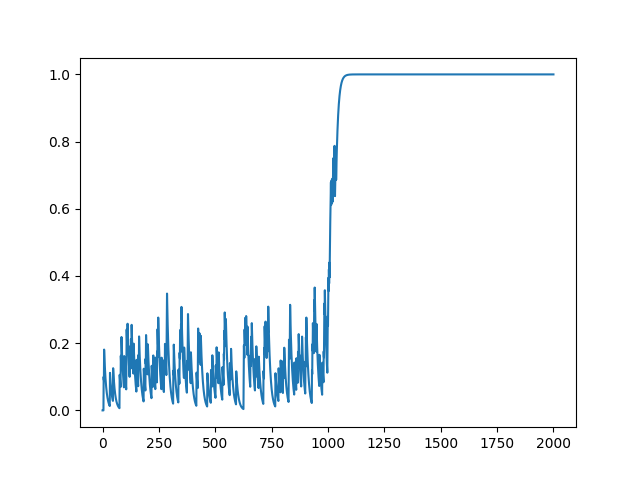

In [514]:
plt.plot(rpe)

## Old code

In [131]:
t = 0
t_max = 100

s = np.zeros(10)
r1 = np.zeros(10)
a = np.zeros(10)
r2_list = []

for i in range(10):
    t_start = t
    s[t] = env.reset()
    done = False
    
    while True:
        a_p = sess.run(ap_op, feed_dict={s_op: s})
        a[t] = np.random.choice(ACTIONS, p=a_p)
        s[t+1], r[t], done, _ = env.step(a[t])
        t += 1        
    if done or t - t_start == t_max:
        break
    
    if done:
        r2 = 0
    else:
        r2 = sess.run(v_op, feed_dict={s_op: s[t]})
    
    for i in range(t-1, t_start-1, -1):
        r2_list.append(r[i] + g * r2)
    
    
    sess.run(t1, feed_dict={s_op: s, big_r_op: r})
    sess.run(t2, feed_dict={s_op: s, big_r_op: r})

0
0
0
0
0
0
0
0
0
0


In [110]:
observation.shape
action = env.action_space.sample()
os = []
for i in range(4):
    o1, _, _, _ = env.step(action)
    o2, _, _, _ = env.step(action)
    o = np.maximum(o1, o2)
    o = np.mean(o, axis=2)
    o = scipy.misc.imresize(o, (84, 84))
    os.append(o)
os = np.stack(os, axis=-1)

In [80]:
os = np.resize(os, (1, 84, 84, 4))
print(os.shape)
print(sess.run(q['network1'], feed_dict={s: os}))
print(sess.run(qi['network1'], feed_dict={s: os}))

(1, 84, 84, 4)
[[  0.69894785  -0.22462213   5.59576368  -7.67884588  16.15483665
    2.82746601   0.95167667   5.31193829   0.30126441]]
[ 16.15483665]
[4]
